In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy.linalg as LA

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.rcParams['text.usetex'] = True

In [2]:
fp = '../Synthetic/Hystersis/SmoothBed_SS_IC/hdf5'

files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '2002a' in file])
xarrays = []

for file in files:
    xarrays.append(xr.open_dataset(file))

SmoothBed_SS_IC = xr.concat(xarrays, 
                       pd.Index(data = np.arange(2.35, 2.46, 0.01), name='Delta_MB'))

SmoothBed_SS_IC["H"] = SmoothBed_SS_IC.z_s - SmoothBed_SS_IC.z_b

In [3]:
fp = '../Synthetic/Hystersis/Observed_IC/hdf5'

files   = sorted([os.path.join(fp,file) for file in os.listdir(fp) if file.endswith('.nc') and '2002a' in file])
xarrays = []

for file in files:
    xarrays.append(xr.open_dataset(file))

Observed_IC = xr.concat(xarrays, 
                       pd.Index(data = np.arange(2.35, 2.46, 0.01), name='Delta_MB'))

Observed_IC["H"] = Observed_IC.z_s - Observed_IC.z_b

In [17]:
Observed_IC.H.sel(t=0).integrate("x")

<xarray.DataArray 'H' (Delta_MB: 11)>
array([5942600., 5942600., 5942600., 5942600., 5942600., 5942600.,
       5942600., 5942600., 5942600., 5942600., 5942600.])
Coordinates:
    t         float64 0.0
  * Delta_MB  (Delta_MB) float64 2.35 2.36 2.37 2.38 ... 2.42 2.43 2.44 2.45

In [18]:
SmoothBed_SS_IC.H.sel(t=0).integrate("x")

<xarray.DataArray 'H' (Delta_MB: 11)>
array([4076785.0646075, 4076785.0646075, 4076785.0646075, 4076785.0646075,
       4076785.0646075, 4076785.0646075, 4076785.0646075, 4076785.0646075,
       4076785.0646075, 4076785.0646075, 4076785.0646075])
Coordinates:
    t         float64 0.0
  * Delta_MB  (Delta_MB) float64 2.35 2.36 2.37 2.38 ... 2.42 2.43 2.44 2.45

In [6]:
OIC_vol = Observed_IC.H.integrate("x") / Observed_IC.H.sel(t=0).integrate("x")
SIC_vol = SmoothBed_SS_IC.H.integrate("x") / SmoothBed_SS_IC.H.sel(t=0).integrate("x")

(0.5, 1.5)

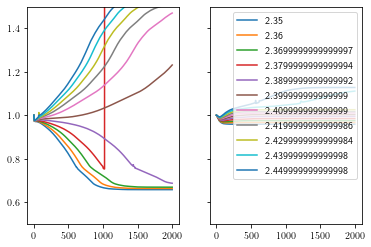

In [7]:
fig, ax = plt.subplots(1,2, sharey=True)


for delta_mb in Observed_IC.Delta_MB:
    
    ax[0].plot(OIC_vol.t, OIC_vol.sel(Delta_MB=delta_mb))
    
    
    ax[1].plot(SIC_vol.t, SIC_vol.sel(Delta_MB=delta_mb), label=delta_mb.values)

ax[1].legend()
ax[1].set_ylim(0.5, 1.5)

In [8]:
delta_mb.values

array(2.45)

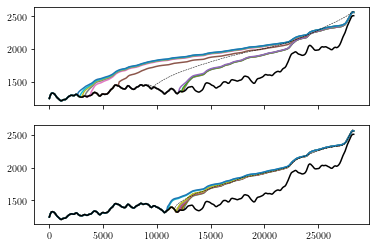

In [16]:
fig, ax = plt.subplots(2,1, sharey=True, sharex=True)


for delta_mb in Observed_IC.Delta_MB:
    
    ax[0].plot(Observed_IC.x, Observed_IC.isel(t=-1).sel(Delta_MB=delta_mb).z_s)
    
    
    ax[1].plot(SmoothBed_SS_IC.x, SmoothBed_SS_IC.isel(t=-1).sel(Delta_MB=delta_mb).z_s)
    
    
ax[0].plot(Observed_IC.x,      Observed_IC.isel(t=-1,Delta_MB=0).z_b, 'k')
ax[0].plot(Observed_IC.x,      Observed_IC.isel(t=0,Delta_MB=0).z_s, c='k', ls='--', lw=0.5)

ax[1].plot(SmoothBed_SS_IC.x,  SmoothBed_SS_IC.isel(t=-1,Delta_MB=0).z_b, 'k')
ax[1].plot(SmoothBed_SS_IC.x,  SmoothBed_SS_IC.isel(t=0, Delta_MB=0).z_s, c='k', ls='--', lw=0.5)

In [20]:
Observed_IC.isel(t=-1.).z_s

<xarray.DataArray 'z_s' (Delta_MB: 11, x: 284)>
array([[1246.        , 1297.        , 1325.        , ..., 2551.39175183,
        2569.28884118, 2564.26393229],
       [1246.        , 1297.        , 1325.        , ..., 2551.43739654,
        2569.32639021, 2564.29913395],
       [1246.        , 1297.        , 1325.        , ..., 2551.48301121,
        2569.36386934, 2564.33424461],
       ...,
       [1246.        , 1297.        , 1325.        , ..., 2551.97659609,
        2570.28026003, 2563.92375913],
       [1246.        , 1297.        , 1325.        , ..., 2552.01731858,
        2570.52060214, 2563.75310749],
       [1246.        , 1297.        , 1325.        , ..., 2552.07662103,
        2570.55942858, 2563.79095793]])
Coordinates:
    t         float64 2e+03
  * x         (x) float64 0.0 100.0 200.0 300.0 ... 2.81e+04 2.82e+04 2.83e+04
  * Delta_MB  (Delta_MB) float64 2.35 2.36 2.37 2.38 ... 2.42 2.43 2.44 2.45
Attributes:
    description:  Surface Elevation
    units:        m a.s.l.